In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from ray import tune
from ray import train
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\TonVo\anaconda3\envs\myenv3.10\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


First we need to repeat all the steps to load the data and create the model.

In [2]:
torch.manual_seed(2023)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
data = pd.read_excel('dataset_final.xlsx')
data = data.dropna(thresh=len(data.columns)-10)
data = data.fillna(method='ffill')
data.tail()

C:\Users\TonVo\AppData\Local\Temp\ipykernel_41756\2340567172.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


,DATE,NASDAQ100,NASDAQCOM,WILL5000PR,DAAA,DCOILWTICO,DGS30,DPRIME,T10Y2Y,T10Y3M,...,VOLUME,RETURN,ADL,WR,RVI,EMA,TR,UO,AAPL,MSFT
9788,2023-09-19,15191.23,13678.19,44733.86,5.10,91.16,4.43,8.5,-0.71,-1.17,...,3.614880e+09,-0.002151,2.153461e+12,-78.0646,0.6052,4463.8448,36.9199,4.2918,179.070007,328.649994
9789,2023-09-20,14969.92,13469.13,44327.34,5.07,89.20,4.40,8.5,-0.77,-1.21,...,3.308450e+09,-0.009395,2.150244e+12,-99.4135,0.3447,4455.6255,59.6499,2.5001,175.490005,320.769989
9790,2023-09-21,14694.24,13223.98,43579.31,5.21,89.56,4.56,8.5,-0.63,-1.08,...,3.662340e+09,-0.016401,2.146712e+12,-99.6086,0.2868,4438.8754,73.0303,0.6814,173.929993,319.529999
9791,2023-09-22,14701.10,13211.81,43482.13,5.15,90.00,4.53,8.5,-0.66,-1.12,...,3.349570e+09,-0.002296,2.143947e+12,-98.1952,0.2777,4423.0334,40.9097,0.1672,174.789993,317.010010
9792,2023-09-25,14768.90,13271.32,43654.44,5.29,89.68,4.67,8.5,-0.54,-1.03,...,3.195650e+09,0.004023,2.146952e+12,-83.4011,0.4286,4411.6209,35.8096,0.0924,176.080002,317.540009


In [4]:
def split_data(data, lookback):
    data_raw = data.to_numpy()
    X_list = []
    y_list = []

    for index in range(len(data_raw) - lookback): 
        X_list.append(data_raw[index: index + lookback, 1:])
        y_list.append(data_raw[index + lookback, -9])

    X = np.array(X_list)
    y = np.array(y_list)

    return X, y

lookback = 14

X, y = split_data(data, lookback)

In [5]:
train_length = int(len(X) * 0.85)
val_length = int(len(X) * 0.05)
test_length = len(X) - train_length - val_length

In [6]:
X_train = X[:train_length]
y_train = y[:train_length]

X_val = X[train_length:train_length+val_length]
y_val = y[train_length:train_length+val_length]

X_test = X[train_length+val_length:]
y_test = y[train_length+val_length:]

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_2D = X_train.reshape(-1, X_train.shape[-1])

X_train_scaled_2D = scaler.fit_transform(X_train_2D)

X_train_scaled = X_train_scaled_2D.reshape(X_train.shape)

X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [11]:
X_train_t = torch.tensor(X_train_scaled).float()
y_train_t = torch.tensor(y_train).float()

X_val_t = torch.tensor(X_val_scaled).float()
y_val_t = torch.tensor(y_val).float()

X_test_t = torch.tensor(X_test_scaled).float()
y_test_t = torch.tensor(y_test).float()

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(LSTMModel, self).__init__()
        
        self.lstm_layers = nn.ModuleList()
        
        self.lstm_layers.append(nn.LSTM(input_dim, hidden_dims[0], batch_first=True))
        
        for i in range(1, len(hidden_dims)):
            self.lstm_layers.append(nn.LSTM(hidden_dims[i-1], hidden_dims[i], batch_first=True))
        
        self.fc1 = nn.Linear(hidden_dims[-1], 64)
        self.leakyrelu1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        for lstm in self.lstm_layers:
            x, _ = lstm(x)
        
        x = x[:, -1, :]
        
        x = self.fc1(x)
        x = self.leakyrelu1(x)
        x = self.fc2(x)
        
        return x

In [9]:
input_dim = 22
output_dim = 1

In [13]:
model = LSTMModel(22, [256, 512, 256, 128], 1).to(device)

model.load_state_dict(torch.load(r'')) # replace with your model path

<All keys matched successfully>

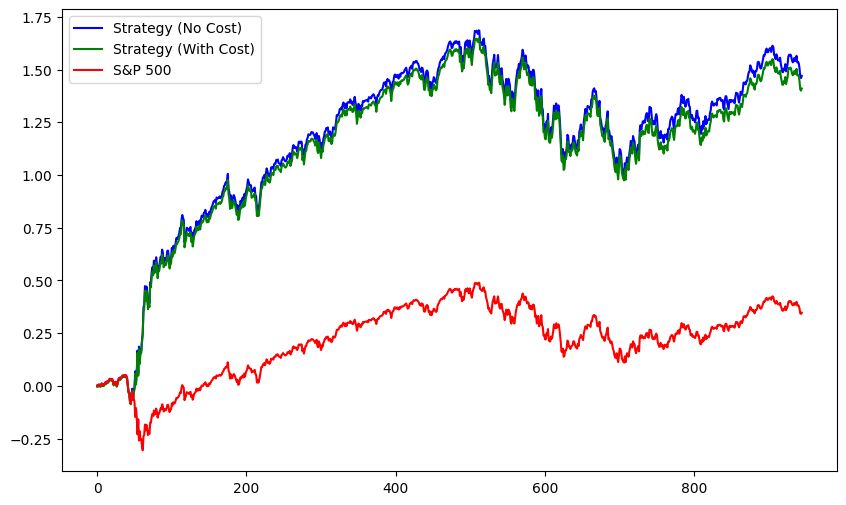

In [14]:
outputs_test = model(X_test_t.to(device))

outputs1_np = outputs_test.detach().cpu().numpy()
y_test1_t_np = y_test_t.detach().cpu().numpy()

df = pd.DataFrame({
    'PredictedReturn': outputs1_np.flatten(),
    'AssetReturn': y_test1_t_np.flatten()
})

df['Signal'] = np.sign(df['PredictedReturn'])

trading_cost = 0.005

df['StrategyReturnNoCost'] = df['Signal'] * df['AssetReturn']

df['StrategyReturnWithCost'] = df['StrategyReturnNoCost'] - trading_cost * (df['Signal'].diff() != 0)

df['CumulativeReturnNoCost'] = (1 + df['StrategyReturnNoCost']).cumprod() - 1

df['CumulativeReturnWithCost'] = (1 + df['StrategyReturnWithCost']).cumprod() - 1

df['BenchmarkCumulativeReturn'] = (1 + df['AssetReturn']).cumprod() - 1

plt.figure(figsize=(10,6))
plt.plot(df['CumulativeReturnNoCost'], label='Strategy (No Cost)', color='blue')
plt.plot(df['CumulativeReturnWithCost'], label='Strategy (With Cost)', color='green')
plt.plot(df['BenchmarkCumulativeReturn'], label='S&P 500', color='red')
plt.legend()
plt.show()

Now we can start calculating the performance metrics. Let's first start with the max_drawdown:

In [15]:
def calculate_max_drawdown(cumulative_return_series):
    normalized_series = (cumulative_return_series + 1) * 100
    running_max = np.maximum.accumulate(normalized_series)
    drawdown = normalized_series - running_max
    mdd = drawdown / running_max
    return mdd.min()

strategy_mdd = calculate_max_drawdown(df['CumulativeReturnWithCost'])

benchmark_mdd = calculate_max_drawdown(df['BenchmarkCumulativeReturn'])

print(f'Maximum Strategy Drawdown: {strategy_mdd * 100:.2f}%')
print(f'Maximum Benchmark Drawdown: {benchmark_mdd * 100:.2f}%')

Maximum Strategy Drawdown: -25.43%
Maximum Benchmark Drawdown: -33.92%


And the Sharpe ratio:

In [16]:
sharpe_ratio_with_cost = np.sqrt(252) * df['StrategyReturnWithCost'].mean() / df['StrategyReturnWithCost'].std()

sharpe_ratio_benchmark = np.sqrt(252) * df['AssetReturn'].mean() / df['AssetReturn'].std()

print(f"Sharpe Ratio with Cost: {sharpe_ratio_with_cost}")
print(f"Sharpe Ratio Benchmark: {sharpe_ratio_benchmark}")

Sharpe Ratio with Cost: 1.1186983831068116
Sharpe Ratio Benchmark: 0.4555817005333269


Now we look at the first 150 observations and repeat the same calculations:

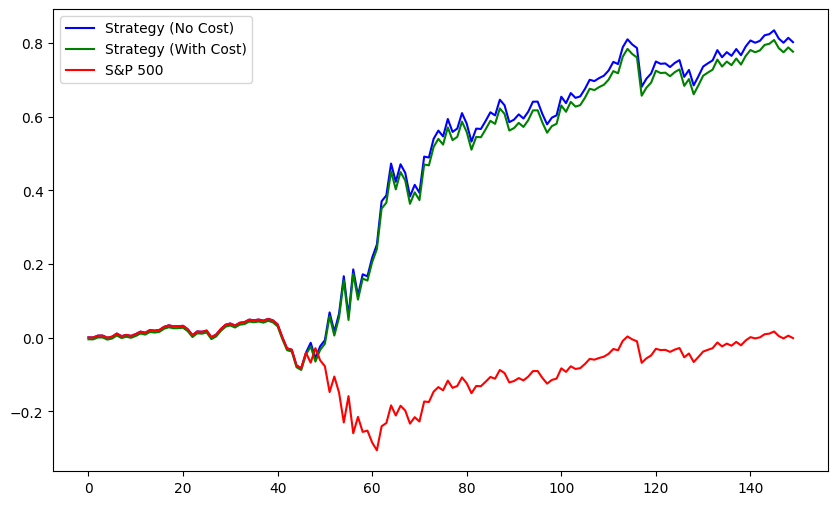

In [17]:
df = pd.DataFrame({
    'PredictedReturn': outputs1_np.flatten(),
    'AssetReturn': y_test1_t_np.flatten()
})

df['Signal'] = np.sign(df['PredictedReturn'])

trading_cost = 0.005

df['StrategyReturnNoCost'] = df['Signal'] * df['AssetReturn']

df['StrategyReturnWithCost'] = df['StrategyReturnNoCost'] - trading_cost * (df['Signal'].diff() != 0)

df['CumulativeReturnNoCost'] = (1 + df['StrategyReturnNoCost']).cumprod() - 1

df['CumulativeReturnWithCost'] = (1 + df['StrategyReturnWithCost']).cumprod() - 1

df['BenchmarkCumulativeReturn'] = (1 + df['AssetReturn']).cumprod() - 1

df = df.iloc[:150]

plt.figure(figsize=(10,6))
plt.plot(df['CumulativeReturnNoCost'], label='Strategy (No Cost)', color='blue')
plt.plot(df['CumulativeReturnWithCost'], label='Strategy (With Cost)', color='green')
plt.plot(df['BenchmarkCumulativeReturn'], label='S&P 500', color='red')
plt.legend()
plt.show()

In [18]:
def calculate_max_drawdown(cumulative_return_series):
    normalized_series = (cumulative_return_series + 1) * 100
    running_max = np.maximum.accumulate(normalized_series)
    drawdown = normalized_series - running_max
    mdd = drawdown / running_max
    return mdd.min()

strategy_mdd = calculate_max_drawdown(df['CumulativeReturnWithCost'])

benchmark_mdd = calculate_max_drawdown(df['BenchmarkCumulativeReturn'])

print(f'Maximum Strategy Drawdown: {strategy_mdd * 100:.2f}%')
print(f'Maximum Benchmark Drawdown: {benchmark_mdd * 100:.2f}%')

Maximum Strategy Drawdown: -12.76%
Maximum Benchmark Drawdown: -33.92%


In [19]:
sharpe_ratio_with_cost = np.sqrt(252) * df['StrategyReturnWithCost'].mean() / df['StrategyReturnWithCost'].std()

sharpe_ratio_benchmark = np.sqrt(252) * df['AssetReturn'].mean() / df['AssetReturn'].std()

print(f"Sharpe Ratio with Cost: {sharpe_ratio_with_cost}")
print(f"Sharpe Ratio Benchmark: {sharpe_ratio_benchmark}")

Sharpe Ratio with Cost: 2.5286867665749364
Sharpe Ratio Benchmark: 0.20897386645005575
